# Ground truth spectra EDA

## Notebook set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


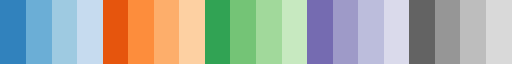

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Local imports
import configuration as config

# Create figures directory for saving plots
figures_dir = f'{config.FIGURES_DIRECTORY}/EDA'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

config.COLORMAP

## 1. Inspect

In [2]:
# Load ground truth spectra dataset
spectra_df = pd.read_csv('./data/raw/train.csv')
spectra_df.head()

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,34983,0.018291,0.018088,0.018087,0.018085,0.018084,0.018084,0.018084,0.018084,0.018085,...,0.018109,0.018112,0.018118,0.018123,0.018125,0.018127,0.018130,0.018134,0.018138,0.018142
1,1873185,0.006347,0.006343,0.006343,0.006343,0.006343,0.006343,0.006343,0.006342,0.006342,...,0.006340,0.006340,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339,0.006339
2,3849793,0.046061,0.046139,0.046130,0.046117,0.046107,0.046105,0.046109,0.046112,0.046111,...,0.046144,0.046133,0.046131,0.046138,0.046141,0.046147,0.046147,0.046139,0.046134,0.046133
3,8456603,0.015363,0.015387,0.015385,0.015385,0.015385,0.015385,0.015384,0.015383,0.015383,...,0.015471,0.015471,0.015467,0.015465,0.015465,0.015464,0.015461,0.015460,0.015460,0.015460
4,23615382,0.014474,0.014636,0.014628,0.014635,0.014643,0.014642,0.014637,0.014635,0.014639,...,0.014473,0.014467,0.014433,0.014426,0.014435,0.014422,0.014399,0.014429,0.014444,0.014418


In [3]:
# Check data structure and completeness
spectra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Columns: 284 entries, planet_id to wl_283
dtypes: float64(283), int64(1)
memory usage: 2.4 MB


## 2. Spectral distribution by wavelength

In [4]:
# Get wavelength columns (excluding planet_id and wl_1)
# Only include columns that match the pattern wl_X where X is a number
wavelength_cols = [col for col in spectra_df.columns if col.startswith('wl_') and col[3:].isdigit() and col != 'wl_1']

print(f"Excluded 'wl_1' from analysis. Using {len(wavelength_cols)} wavelength columns.")
print(f'Wavelength columns range from {wavelength_cols[0]} to {wavelength_cols[-1]}')

# Standardize each planet's spectral distribution before creating histogram
# Get the spectral data for all wavelengths
planet_spectra_data = spectra_df[wavelength_cols].values

# Calculate planet-specific mean and standard deviation for each planet (across wavelengths)
planet_means = np.mean(planet_spectra_data, axis=1, keepdims=True)  # Shape: (n_planets, 1)
planet_stds = np.std(planet_spectra_data, axis=1, keepdims=True)    # Shape: (n_planets, 1)

# Standardize the data: (value - planet_mean) / planet_std for each planet
standardized_spectra_data = (planet_spectra_data - planet_means) / planet_stds

print(f'Planet-specific standardization completed.')
print(f'Standardized flux range: {np.min(standardized_spectra_data):.4f} ' +
      f'to {np.max(standardized_spectra_data):.4f}')

# Create bins for standardized flux values - use symmetric range around 0
flux_min_std = np.min(standardized_spectra_data)
flux_max_std = np.max(standardized_spectra_data)

# Use symmetric range for diverging colormap
flux_range = max(abs(flux_min_std), abs(flux_max_std))
bins_std = np.linspace(-flux_range, flux_range, 51)  # 50 bins
bin_centers_std = (bins_std[:-1] + bins_std[1:]) / 2

# Create histogram matrix: rows = wavelengths, columns = binned standardized fluxes
heatmap_data_std = np.zeros((len(wavelength_cols), len(bin_centers_std)))

# Generate histogram data for each wavelength
for i, wavelength in enumerate(wavelength_cols):
    counts, _ = np.histogram(standardized_spectra_data[:, i], bins=bins_std)
    heatmap_data_std[i, :] = counts

Excluded 'wl_1' from analysis. Using 282 wavelength columns.
Wavelength columns range from wl_2 to wl_283
Planet-specific standardization completed.
Standardized flux range: -3.1711 to 4.6100


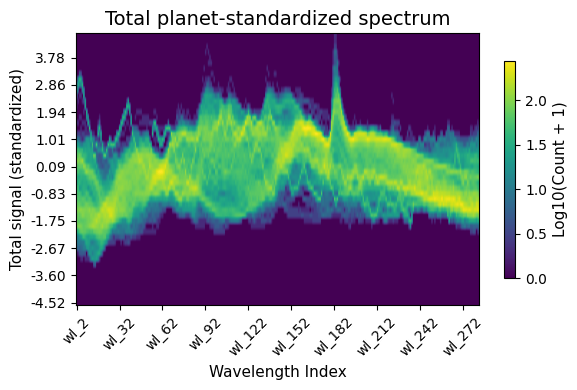


Dataset info:
Number of wavelengths: 282
Number of samples: 1100
Standardized flux range: -3.1711 to 4.6100
fNumber of bins used: {n_bins_std}
Bin range (symmetric): -4.6100 to 4.6100


In [5]:
# Create heatmap with diverging colormap for standardized spectral distributions
# Extract wavelength numbers from column names (wl_0, wl_2, wl_3, etc.)
wavelength_numbers = [int(col.split('_')[1]) for col in wavelength_cols]

# Apply log scale to the heatmap data (add 1 to avoid log(0))
log_heatmap_data_std = np.log10(heatmap_data_std + 1)

# Transpose the data to swap axes: wavelength on x-axis, flux values on y-axis
log_heatmap_data_transposed = log_heatmap_data_std.T

plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH - 2))

# Use a diverging colormap since we're dealing with standardized (centered around 0) flux values
im = plt.imshow(
    log_heatmap_data_transposed,
    aspect='auto',
    cmap='viridis',
    origin='lower'
)

# Set ticks and labels - now wavelength is on x-axis, flux on y-axis
plt.xticks(
    range(0, len(wavelength_cols), 30),
    [f'wl_{wavelength_numbers[i]}' for i in range(0, len(wavelength_cols), 30)],
    rotation=45
)

n_bins_std = len(bin_centers_std)

plt.yticks(
    range(0, n_bins_std, 5),
    [f'{bin_centers_std[i]:.2f}' for i in range(0, n_bins_std, 5)]
)

plt.title('Total planet-standardized spectrum', fontsize=14)
plt.xlabel('Wavelength Index', fontsize=11)
plt.ylabel('Total signal (standardized)', fontsize=11)

# Add colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Log10(Count + 1)', fontsize=11)

plt.tight_layout()

# Save the figure
plt.savefig(
    f'{figures_dir}/01.2.1-flux_distribution_by_wavelength.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()

# Summary statistics
print(f'\nDataset info:')
print(f'Number of wavelengths: {len(wavelength_cols)}')
print(f'Number of samples: {len(spectra_df)}')
print(f'Standardized flux range: {flux_min_std:.4f} to {flux_max_std:.4f}')
print('fNumber of bins used: {n_bins_std}')
print(f'Bin range (symmetric): -{flux_range:.4f} to {flux_range:.4f}')

## 3. Total flux by planet

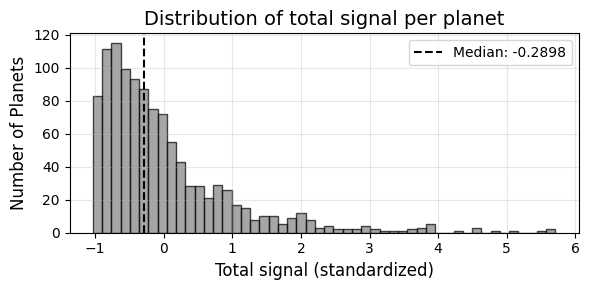

Original mean: 4.1424, std: 3.0051


In [6]:
# Calculate total flux for each planet by summing wavelength columns (excluding wl_1)
wavelength_sum_cols = [col for col in spectra_df.columns if col.startswith('wl_') and col[3:].isdigit() and col != 'wl_1']

# Calculate total flux for each planet
spectra_df['total_flux'] = spectra_df[wavelength_sum_cols].sum(axis=1)

# Standardize the total flux values across the dataset
total_flux_mean = spectra_df['total_flux'].mean()
total_flux_std = spectra_df['total_flux'].std()

spectra_df['total_flux_standardized'] = (
    spectra_df['total_flux'] - total_flux_mean
) / total_flux_std

# Create histogram of standardized total flux
plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH - 3))

plt.hist(
    spectra_df['total_flux_standardized'],
    bins=50,
    color='grey',
    alpha=0.7,
    edgecolor='black'
)

plt.title('Distribution of total signal per planet', fontsize=14)
plt.xlabel('Total signal (standardized)', fontsize=12)
plt.ylabel('Number of Planets', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot the median line for reference
median_std_flux = spectra_df['total_flux_standardized'].median()

plt.axvline(
    median_std_flux,
    color='black',
    linestyle='--',
    label=f'Median: {median_std_flux:.4f}'
)

plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig(
    f'{figures_dir}/01.2.2-total_signal_distribution.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()

print(f"Original mean: {total_flux_mean:.4f}, std: {total_flux_std:.4f}")

## 4. Spectral distribution by planet

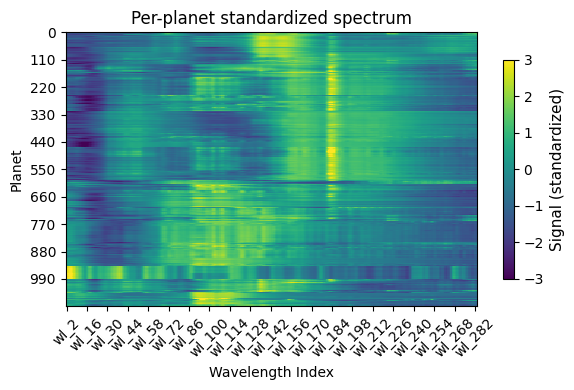

In [7]:
# Standardize using planet-specific mean and std for each planet's spectrum
planet_spectra_data = spectra_df[wavelength_cols].values
planet_ids = spectra_df['planet_id'].values

# Calculate planet-specific mean and standard deviation for each planet (across wavelengths)
planet_means = np.mean(planet_spectra_data, axis=1, keepdims=True)  # Shape: (n_planets, 1)
planet_stds = np.std(planet_spectra_data, axis=1, keepdims=True)    # Shape: (n_planets, 1)

# Standardize the data: (value - planet_mean) / planet_std for each planet
standardized_data = (planet_spectra_data - planet_means) / planet_stds

# Perform hierarchical clustering on standardized planet spectra
n_planets_for_clustering = len(planet_ids)
sampled_planet_ids = planet_ids  # Use all planet IDs

# Compute distance matrix and perform hierarchical clustering
distances = pdist(standardized_data, metric='euclidean')
linkage_matrix = linkage(distances, method='ward')

# Get dendrogram ordering
dendro = dendrogram(
    linkage_matrix, 
    orientation='left',
    no_plot=True  # Calculate ordering but don't plot
)

# Create figure with heatmap only
fig = plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH - 2))

# Get the order of planets from dendrogram (this is the correct ordering)
dendro_idx = dendro['leaves']
ordered_data = standardized_data[dendro_idx, :]
ordered_planet_ids = planet_ids[dendro_idx]

# Create heatmap
display_step = n_planets_for_clustering
display_indices = range(0, n_planets_for_clustering)
display_data = ordered_data[display_indices, :]

# Create single heatmap plot
ax_heatmap = plt.gca()

# Extract wavelength numbers from column names (wl_0, wl_2, wl_3, etc.)
wavelength_numbers = [int(col.split('_')[1]) for col in wavelength_cols]

# Display the clustered spectral data
im = ax_heatmap.imshow(
    display_data,
    aspect='auto',
    cmap='viridis',
    interpolation='nearest', 
    vmin=-3,
    vmax=3
)

# Set ticks and labels for wavelengths (x-axis)
wavelength_step = max(1, len(wavelength_cols) // 20)  # Show every nth wavelength
x_ticks = range(0, len(wavelength_cols), wavelength_step)
x_labels = [f'wl_{wavelength_numbers[i]}' for i in x_ticks]
ax_heatmap.set_xticks(x_ticks)
ax_heatmap.set_xticklabels(x_labels, rotation=45)

# Set ticks and labels for planets (y-axis) - show cluster labels only
planet_step = max(1, len(display_data) // 10)  # Show fewer ticks
y_ticks = range(0, len(display_data), planet_step)
ax_heatmap.set_yticks(y_ticks)

ax_heatmap.set_title(f'Per-planet standardized spectrum', fontsize=12)
ax_heatmap.set_xlabel('Wavelength Index')
ax_heatmap.set_ylabel('Planet')

# Add colorbar
cbar = plt.colorbar(im, ax=ax_heatmap, shrink=0.8)
cbar.set_label('Signal (standardized)', fontsize=11)

plt.tight_layout()

# Save the figure
plt.savefig(
    f'{figures_dir}/01.2.3-hierarchical_clustered_spectra.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()